aggregator_parallel - ppo: Experiment Start Time: 2024-10-25 05:06:47
aggregator_parallel - ppo: 平均 Latency = 191.36 ms
aggregator_parallel - dqn: Experiment Start Time: 2024-10-25 05:14:15
aggregator_parallel - dqn: 平均 Latency = 215.83 ms
aggregator_parallel - cloud: Experiment Start Time: 2024-10-25 06:06:56
aggregator_parallel - cloud: 平均 Latency = 218.78 ms
aggregator_parallel - edge: Experiment Start Time: 2024-10-25 06:14:15
aggregator_parallel - edge: 平均 Latency = 219.63 ms
aggregator_parallel - all: Experiment Start Time: 2024-10-25 05:59:37
aggregator_parallel - all: 平均 Latency = 226.40 ms
['Rescheduling', 'Node Failure', 'Latency', 'Average Latency', 'Moving Average Latency']


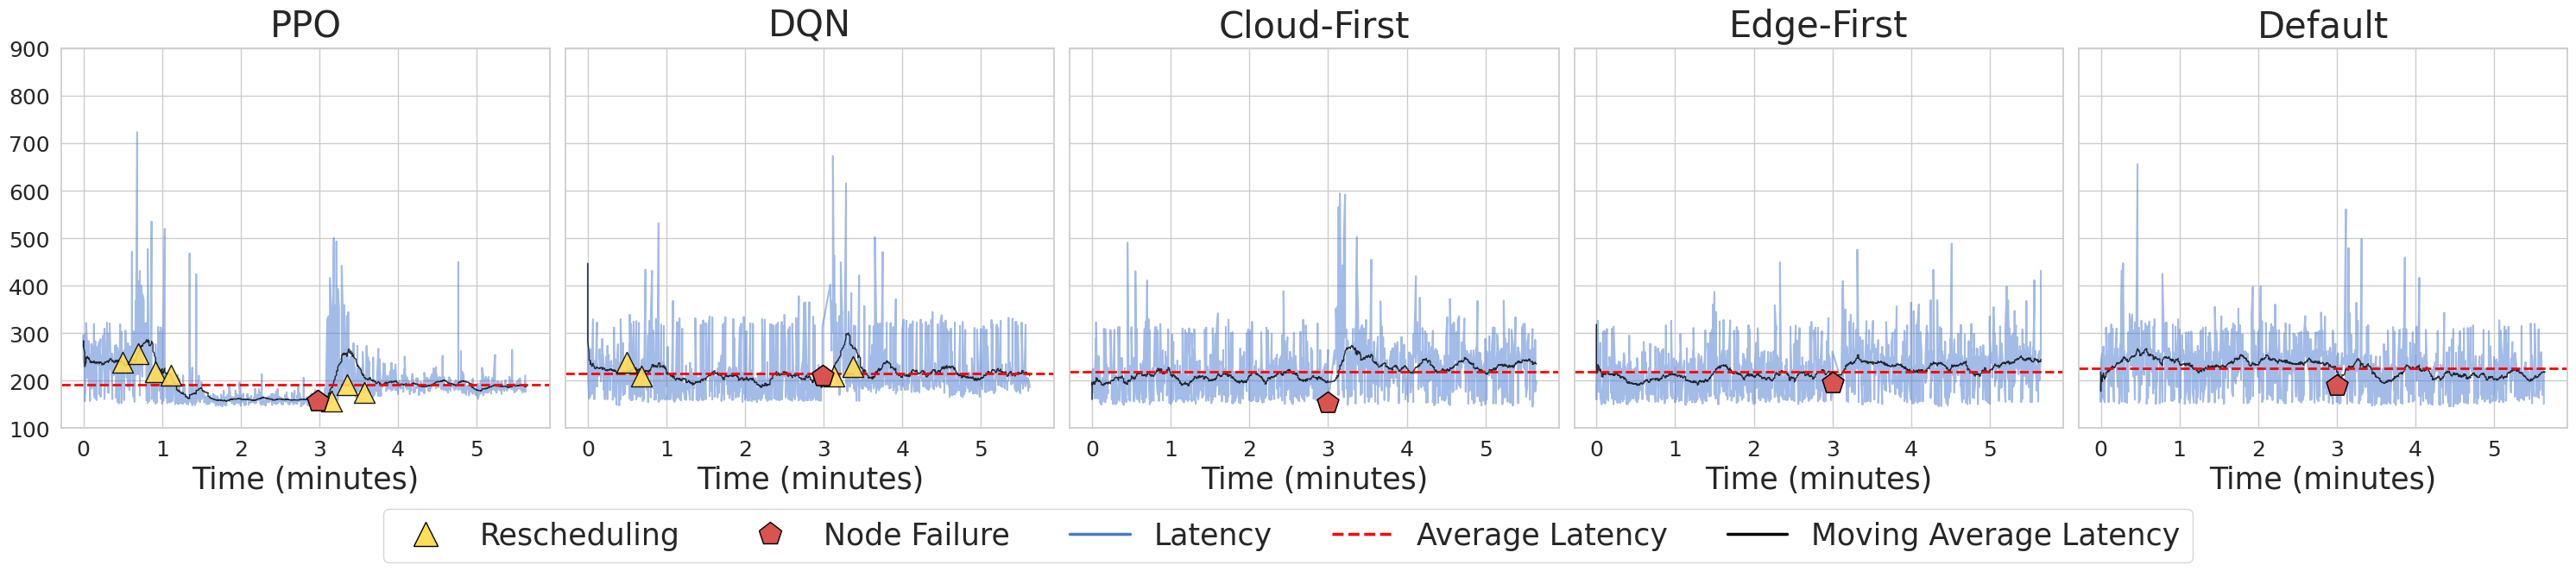

aggregator_sequential - ppo: Experiment Start Time: 2024-10-25 05:36:41
aggregator_sequential - ppo: 平均 Latency = 221.41 ms
aggregator_sequential - dqn: Experiment Start Time: 2024-10-25 05:44:11
aggregator_sequential - dqn: 平均 Latency = 242.01 ms
aggregator_sequential - cloud: Experiment Start Time: 2024-10-25 06:28:52
aggregator_sequential - cloud: 平均 Latency = 265.57 ms
aggregator_sequential - edge: Experiment Start Time: 2024-10-25 06:36:11
aggregator_sequential - edge: 平均 Latency = 267.83 ms
aggregator_sequential - all: Experiment Start Time: 2024-10-25 06:21:34
aggregator_sequential - all: 平均 Latency = 266.47 ms
['Rescheduling', 'Node Failure', 'Latency', 'Average Latency', 'Moving Average Latency']


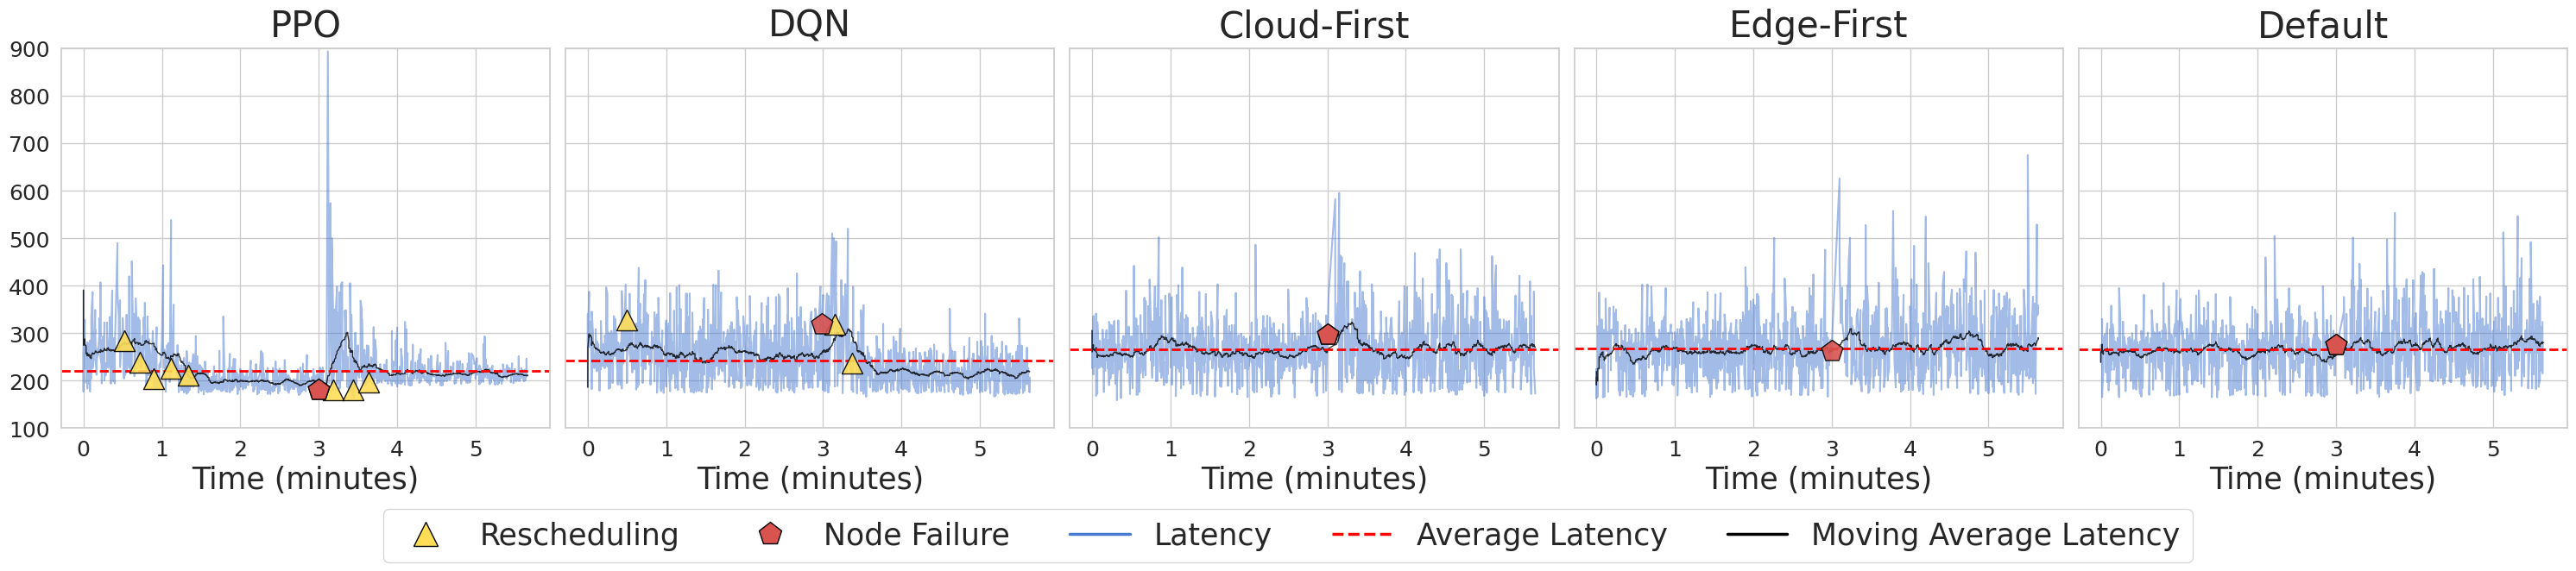

chain - ppo: Experiment Start Time: 2024-10-25 10:39:27
chain - ppo: 平均 Latency = 219.92 ms
chain - dqn: Experiment Start Time: 2024-10-25 10:47:02
chain - dqn: 平均 Latency = 238.86 ms
chain - cloud: Experiment Start Time: 2024-10-25 09:24:54
chain - cloud: 平均 Latency = 278.16 ms
chain - edge: Experiment Start Time: 2024-10-25 09:32:19
chain - edge: 平均 Latency = 264.44 ms
chain - all: Experiment Start Time: 2024-10-25 09:17:33
chain - all: 平均 Latency = 265.39 ms
['Rescheduling', 'Node Failure', 'Latency', 'Average Latency', 'Moving Average Latency']


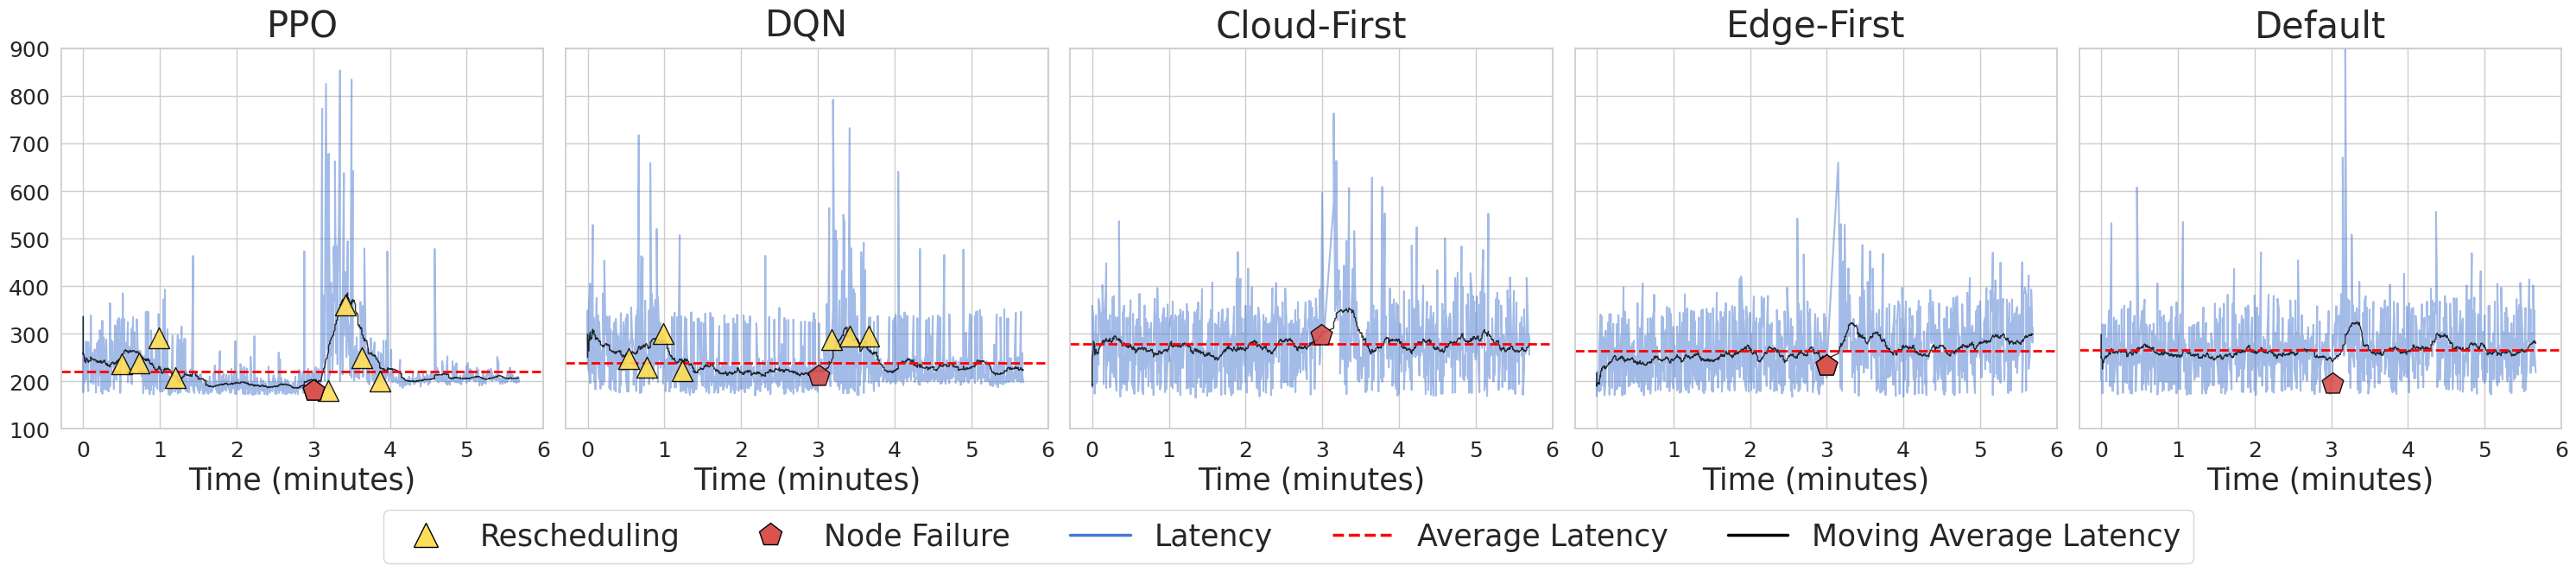

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 设置 Seaborn 主题
sns.set_theme(style="whitegrid")

# 定义 MSA 和策略列表
msa_list = ["aggregator_parallel", "aggregator_sequential", "chain"]
strategy_list = ["ppo", "dqn", "cloud", "edge", "all"]

# 是否为测试模式
isTest = False
testDataPath = "results/nodefailed/aggregator_parallel_ppo_replica3.csv"

# 生成 muted 调色板颜色
palette = sns.color_palette("muted", n_colors=5)

# 配色方案
reschedule_color = "#ffdd57"  # 亮黄色
autoscaling_color = "#d9534f"  # 深橙红色
average_line_color = "#4d4d4d"  # 深灰色

# 逐个 MSA 绘制独立的图表
for msa in msa_list:
    # 创建一个大图，并根据策略数量创建子图 (3行2列)
    # fig, axes = plt.subplots(1, 5, figsize=(30, 5))
    fig = plt.figure(figsize=(30, 6))
    # fig.supylabel('Latency (ms)', fontsize=25, x=0.02)
    gs = fig.add_gridspec(1, 5)
    axes = gs.subplots(sharex=True, sharey=True) 
    # 初始化列表来收集图例句柄和标签
    latency_handles = []
    latency_labels = []

    # 初始化变量以存储 PPO 的平均延迟和颜色
    ppo_latency_mean = None
    ppo_primary_color = None

    # 逐个策略读取数据并绘制在子图中
    for idx, strategy in enumerate(strategy_list):
        # 根据 idx 计算行列位置
        # row = idx // 2
        # col = idx % 2
        ax = axes[idx]

        # 读取数据
        if isTest:
            data = pd.read_csv(testDataPath)
        else:
            # 假设数据保存在 '{msa}_{strategy}_replica3.csv' 文件中
            data_path = f"results/nodefailed/{msa}_{strategy}_replica3.csv"
            if not os.path.exists(data_path):
                print(f"文件未找到: {data_path}")
                continue
            data = pd.read_csv(data_path)

        if data.empty:
            print(f"{msa} - {strategy}: 数据为空，跳过。")
            continue

        # 将 timestamp 转换为 datetime 格式
        data['human_readable_timestamp'] = pd.to_datetime(data['human_readable_timestamp'], errors='coerce')
        data = data.dropna(subset=['human_readable_timestamp'])

        # 对数据按 timestamp 进行排序
        data = data.sort_values(by='human_readable_timestamp')

        # 找到第一个 'experiment_start' 的时间
        experiment_start_time = data[data['event'] == 'experiment_start']['human_readable_timestamp'].min()
        print(f"{msa} - {strategy}: Experiment Start Time:", experiment_start_time)

        # 丢弃 'experiment_start' 及之前的所有数据
        data = data[data['human_readable_timestamp'] > experiment_start_time]

        # 确保过滤掉任何不合理的值，例如负数或异常大的值 (optional)
        # print(f"{msa} - {strategy}: 过滤前行数: {len(data)}")
        # data = data[(data['latency'] >= 0) & (data['latency'] < 500)]
        # print(f"{msa} - {strategy}: 过滤后行数: {len(data)}")

        if data.empty:
            print(f"{msa} - {strategy}: 过滤后数据为空，跳过。")
            continue

        # 以第一个时间点为基准，将时间转换为相对时间
        baseline_time = data['human_readable_timestamp'].min()  # 统一基准时间
        data['relative_time'] = (data['human_readable_timestamp'] - baseline_time).dt.total_seconds() / 60  # 转换为分钟

        # 移除非 latency 事件的数据点，但保留 'rescheduling' 和 'node_failed' 事件
        data.loc[data['event'].isin(['experiment_end', 'node_recovered']), 'latency'] = None

        # 计算移动平均 (窗口大小为40)
        data['latency_moving_avg'] = data['latency'].rolling(window=40, min_periods=1).mean()

        # 计算 latency 平均值并打印
        latency_mean = data['latency'].mean()
        print(f"{msa} - {strategy}: 平均 Latency = {latency_mean:.2f} ms")

        # 使用不同 muted 调色板颜色
        primary_color = palette[0]

        # 如果是 PPO，存储其平均延迟和颜色
        if strategy == 'ppo':
            ppo_latency_mean = latency_mean
            ppo_primary_color = primary_color

        # 绘制延迟折线图（不在图例中显示）
        ax.plot(data['relative_time'], data['latency'],
                color=primary_color, linewidth=1.5, alpha=0.5)

        # 绘制移动平均线
        ax.plot(data['relative_time'], data['latency_moving_avg'],
                color="black", linewidth=1, alpha=0.8)

        # 创建线段图标并添加到句柄列表
        # line_handle = plt.Line2D([], [], color=primary_color, linewidth=2.5, label=f'{strategy.upper()}')
        # latency_handles.append(line_handle)
        # latency_labels.append(f'{strategy.upper()}')

        # 绘制平均线，根据策略调整颜色
        # if strategy == 'ppo':
        #     # 在 PPO 子图中，平均线使用蓝色
        #     ax.axhline(latency_mean, color='blue', linestyle='--', linewidth=2.0)
        # else:
            # 其他策略子图中，平均线使用红色
        ax.axhline(latency_mean, color="red", linestyle='--', linewidth=2.0)
            # 并在其他子图上添加 PPO 的平均线
            # if ppo_latency_mean is not None:
            #     ax.axhline(ppo_latency_mean, color="blue", linestyle='--', linewidth=2.0)

        # 筛选出 rescheduling 和 node_failed 事件
        reschedule_events = data[data['event'] == 'rescheduling']
        node_failed_events = data[data['event'] == 'node_failed']

        # 标记 rescheduling 事件
        ax.scatter(reschedule_events['relative_time'], reschedule_events['latency'],
                   color=reschedule_color, label='Rescheduling', marker='^', s=300, edgecolor='black', alpha=0.9, zorder=5)

        # 标记 node_failed 事件
        ax.scatter(node_failed_events['relative_time'], node_failed_events['latency'],
                   color=autoscaling_color, label='Node Failed', marker='p', s=350, edgecolor='black', alpha=0.9, zorder=5)

        # 图形标注
        ax.set_xlabel("Time (minutes)", fontsize=25)
        # ax.set_ylabel("Latency (ms)", fontsize=25)
        ax.tick_params(axis='y', which='major', labelsize=18)
        ax.tick_params(axis='x', which='major', labelsize=18)
        title_map = {
            "ppo": "PPO",
            "dqn": "DQN",
            "cloud": "Cloud-First",
            "edge": "Edge-First",
            "all": "Default"
        }
        ax.set_title(f"{title_map[strategy]}", fontsize=30, pad=10)
        ax.set_ylim(100, 900)  # 固定 Latency 纵坐标范围为 0 - 500 ms

    # 隐藏未使用的子图（例如第6个子图）
    # axes[2][1].set_visible(False)

    # 创建 rescheduling 和 node_failed 的句柄（仅需创建一次）
    rescheduling_handle = plt.Line2D([], [], color=reschedule_color, marker='^', linestyle='None', markersize=20, markeredgecolor='black', label='Rescheduling')
    node_failed_handle = plt.Line2D([], [], color=autoscaling_color, marker='p', linestyle='None', markersize=20, markeredgecolor='black', label='Node Failed')
    average_line_handle = plt.Line2D([], [], color="red", linestyle='--', linewidth=2.5, label='Average Latency')
    moving_average_line_handle = plt.Line2D([], [], color="black", linestyle='-', linewidth=2.5, label='Moving Average Latency')

    line_handle = plt.Line2D([], [], color=palette[0], linewidth=2.5, label=f'Latency')
    latency_handles.append(line_handle)
    latency_labels.append(f'Latency')
    # 添加 PPO 平均线的句柄
    # if ppo_latency_mean is not None:
    #     ppo_average_line_handle = plt.Line2D([], [], color=ppo_primary_color, linestyle='--', linewidth=2.5, label='PPO Average Latency')
    #     # 调整顺序，使 'Average Latency' 和 'PPO Average Latency' 相邻
    #     legend_handles = (
    #         [rescheduling_handle, node_failed_handle] +
    #         latency_handles +
    #         [average_line_handle, ppo_average_line_handle, moving_average_line_handle]
    #     )
    #     legend_labels = (
    #         ['Rescheduling', 'Node Failure'] +
    #         latency_labels +
    #         ['Average Latency', 'PPO Average Latency', 'Moving Average Latency']
    #     )
    # else:
    legend_handles = (
        [rescheduling_handle, node_failed_handle] +
        latency_handles +
        [average_line_handle, moving_average_line_handle]
    )
    legend_labels = (
        ['Rescheduling', 'Node Failure'] +
        latency_labels +
        ['Average Latency', 'Moving Average Latency']
    )
    print(legend_labels) # ['Rescheduling', 'Node Failure', 'PPO', 'DQN', 'CLOUD', 'EDGE', 'ALL', 'Average Latency', 'PPO Average Latency', 'Moving Average Latency'
    # 在主图中添加图例
    # labels_map = {
    #     'PPO': 'PPO',
    #     'DQN': 'DQN',
    #     'CLOUD': 'Cloud-First',
    #     'EDGE': 'Edge-First',
    #     'ALL': 'Default',
    #     'Rescheduling': 'Rescheduling',
    #     'Node Failure': 'Node Failure',
    #     'Average Latency': 'Average Latency',
    #     'PPO Average Latency': 'PPO Average Latency',
    #     'Moving Average Latency': 'Moving Average Latency'
    # }

    labels_map = {
        'Latency': 'Latency',
        'Rescheduling': 'Rescheduling',
        'Node Failure': 'Node Failure',
        'Average Latency': 'Average Latency',
        'PPO Average Latency': 'PPO Average Latency',
        'Moving Average Latency': 'Moving Average Latency'
    }
    fig.legend(legend_handles, [labels_map[label] for label in legend_labels], fontsize=25, ncol=6, loc='center', bbox_to_anchor=(0.5, -0.05))

    # 调整图形布局
    plt.tight_layout()
    # plt.subplots_adjust(left=0.06)
    # plt.subplots_adjust(wspace=0.4)
    # 如果需要保存图表，可以取消下面的注释
    plt.savefig(f"output/timeseries/latency_{msa}.png", dpi=300, bbox_inches='tight')

    # 显示图表
    plt.show()


chain - ppo: Experiment Start Time: 2024-12-14 12:12:32
chain - ppo: 平均 Latency = 197.55 ms
chain - ppo: 延迟小于300ms的latency占总的百分比 = 0.90
chain - ppo: 平均 RPS = 26.62
chain - dqn: Experiment Start Time: 2024-12-14 12:18:33
chain - dqn: 平均 Latency = 207.29 ms
chain - dqn: 延迟小于300ms的latency占总的百分比 = 0.89
chain - dqn: 平均 RPS = 25.45
chain - cloud: Experiment Start Time: 2024-12-14 12:36:06
chain - cloud: 平均 Latency = 258.77 ms
chain - cloud: 延迟小于300ms的latency占总的百分比 = 0.57
chain - cloud: 平均 RPS = 21.23
chain - edge: Experiment Start Time: 2024-12-14 12:42:07
chain - edge: 平均 Latency = 258.02 ms
chain - edge: 延迟小于300ms的latency占总的百分比 = 0.55
chain - edge: 平均 RPS = 21.23
chain - all: Experiment Start Time: 2024-12-14 12:30:04
chain - all: 平均 Latency = 255.12 ms
chain - all: 延迟小于300ms的latency占总的百分比 = 0.59
chain - all: 平均 RPS = 21.47
['Rescheduling', 'RPS Burst', 'Latency', 'Average Latency', 'Moving Average Latency']


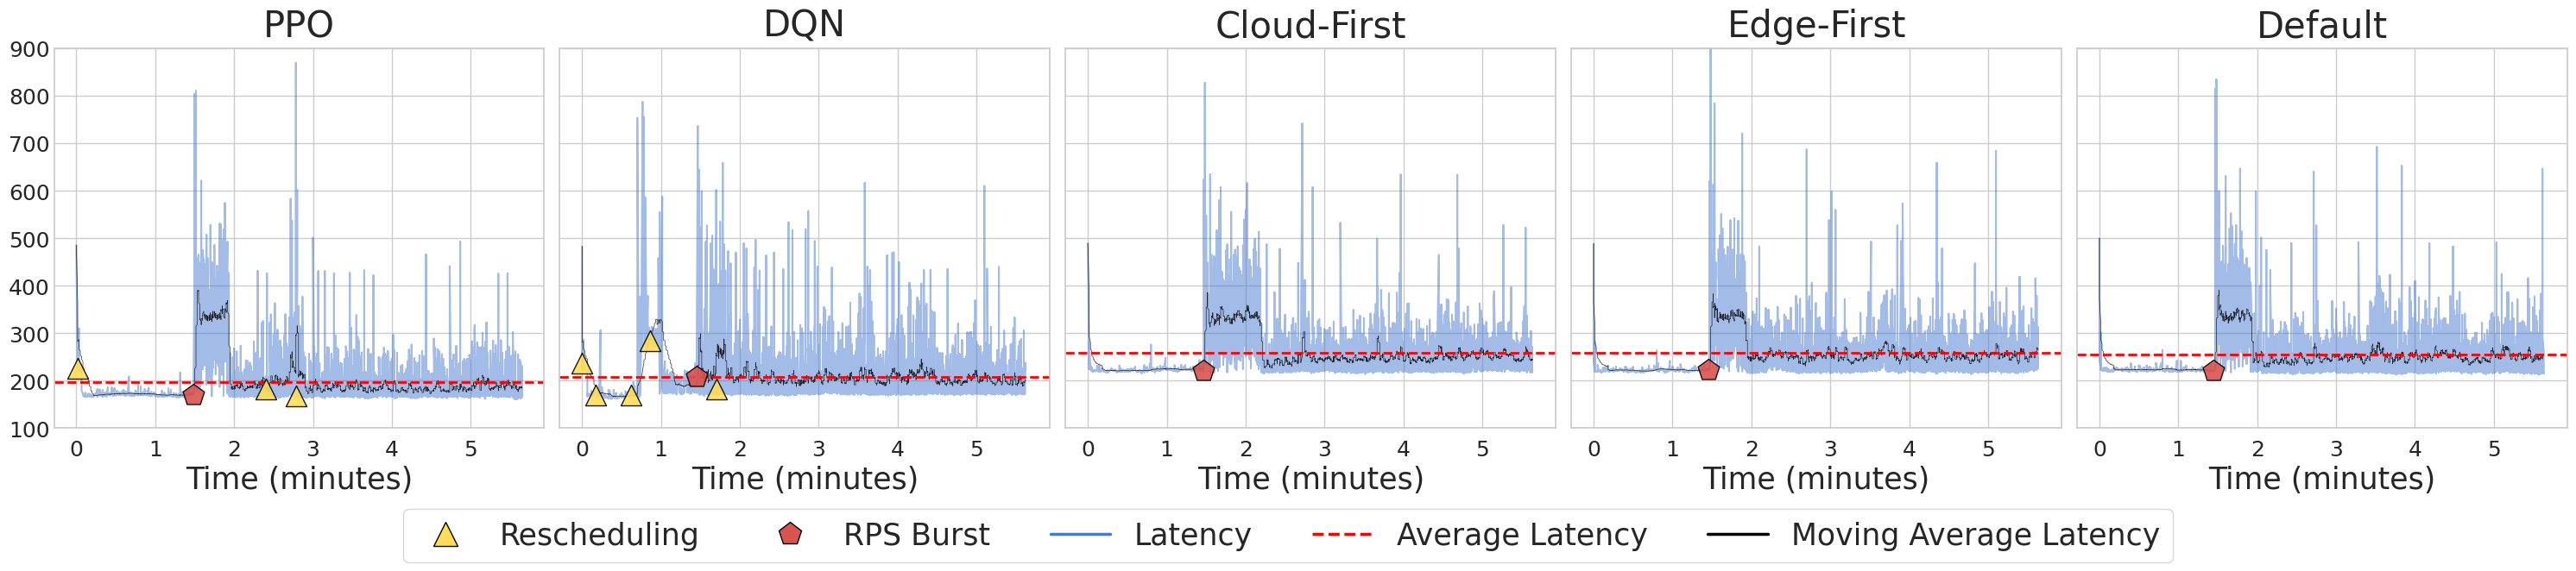

aggregator_sequential - ppo: Experiment Start Time: 2024-12-14 11:49:51
aggregator_sequential - ppo: 平均 Latency = 190.92 ms
aggregator_sequential - ppo: 延迟小于300ms的latency占总的百分比 = 0.92
aggregator_sequential - ppo: 平均 RPS = 26.88
aggregator_sequential - dqn: Experiment Start Time: 2024-12-14 11:55:59
aggregator_sequential - dqn: 平均 Latency = 198.09 ms
aggregator_sequential - dqn: 延迟小于300ms的latency占总的百分比 = 0.90
aggregator_sequential - dqn: 平均 RPS = 26.52
aggregator_sequential - cloud: Experiment Start Time: 2024-12-14 14:37:04
aggregator_sequential - cloud: 平均 Latency = 238.63 ms
aggregator_sequential - cloud: 延迟小于300ms的latency占总的百分比 = 0.78
aggregator_sequential - cloud: 平均 RPS = 22.77
aggregator_sequential - edge: Experiment Start Time: 2024-12-14 14:43:10
aggregator_sequential - edge: 平均 Latency = 239.98 ms
aggregator_sequential - edge: 延迟小于300ms的latency占总的百分比 = 0.77
aggregator_sequential - edge: 平均 RPS = 22.65
aggregator_sequential - all: Experiment Start Time: 2024-12-14 14:30:57
aggr

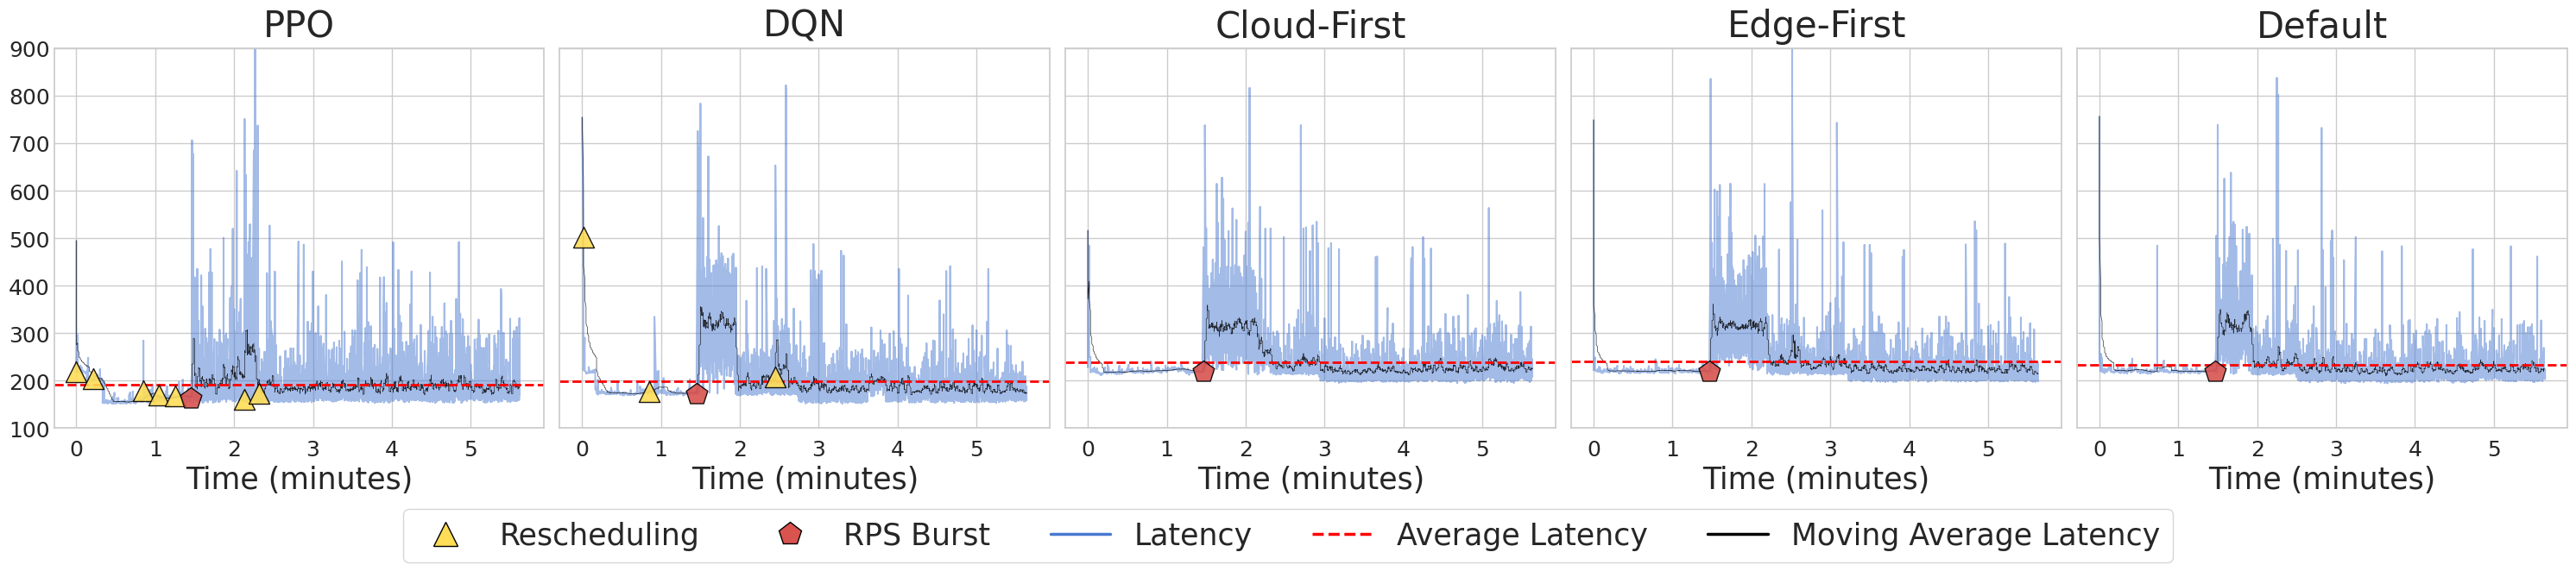

aggregator_parallel - ppo: Experiment Start Time: 2024-12-14 13:56:52
aggregator_parallel - ppo: 平均 Latency = 181.82 ms
aggregator_parallel - ppo: 延迟小于300ms的latency占总的百分比 = 0.93
aggregator_parallel - ppo: 平均 RPS = 27.88
aggregator_parallel - dqn: Experiment Start Time: 2024-12-14 14:02:56
aggregator_parallel - dqn: 平均 Latency = 212.63 ms
aggregator_parallel - dqn: 延迟小于300ms的latency占总的百分比 = 0.81
aggregator_parallel - dqn: 平均 RPS = 24.90
aggregator_parallel - cloud: Experiment Start Time: 2024-12-14 14:18:42
aggregator_parallel - cloud: 平均 Latency = 229.33 ms
aggregator_parallel - cloud: 延迟小于300ms的latency占总的百分比 = 0.78
aggregator_parallel - cloud: 平均 RPS = 23.54
aggregator_parallel - edge: Experiment Start Time: 2024-12-14 14:24:50
aggregator_parallel - edge: 平均 Latency = 227.01 ms
aggregator_parallel - edge: 延迟小于300ms的latency占总的百分比 = 0.79
aggregator_parallel - edge: 平均 RPS = 23.77
aggregator_parallel - all: Experiment Start Time: 2024-12-14 14:12:35
aggregator_parallel - all: 平均 Latency 

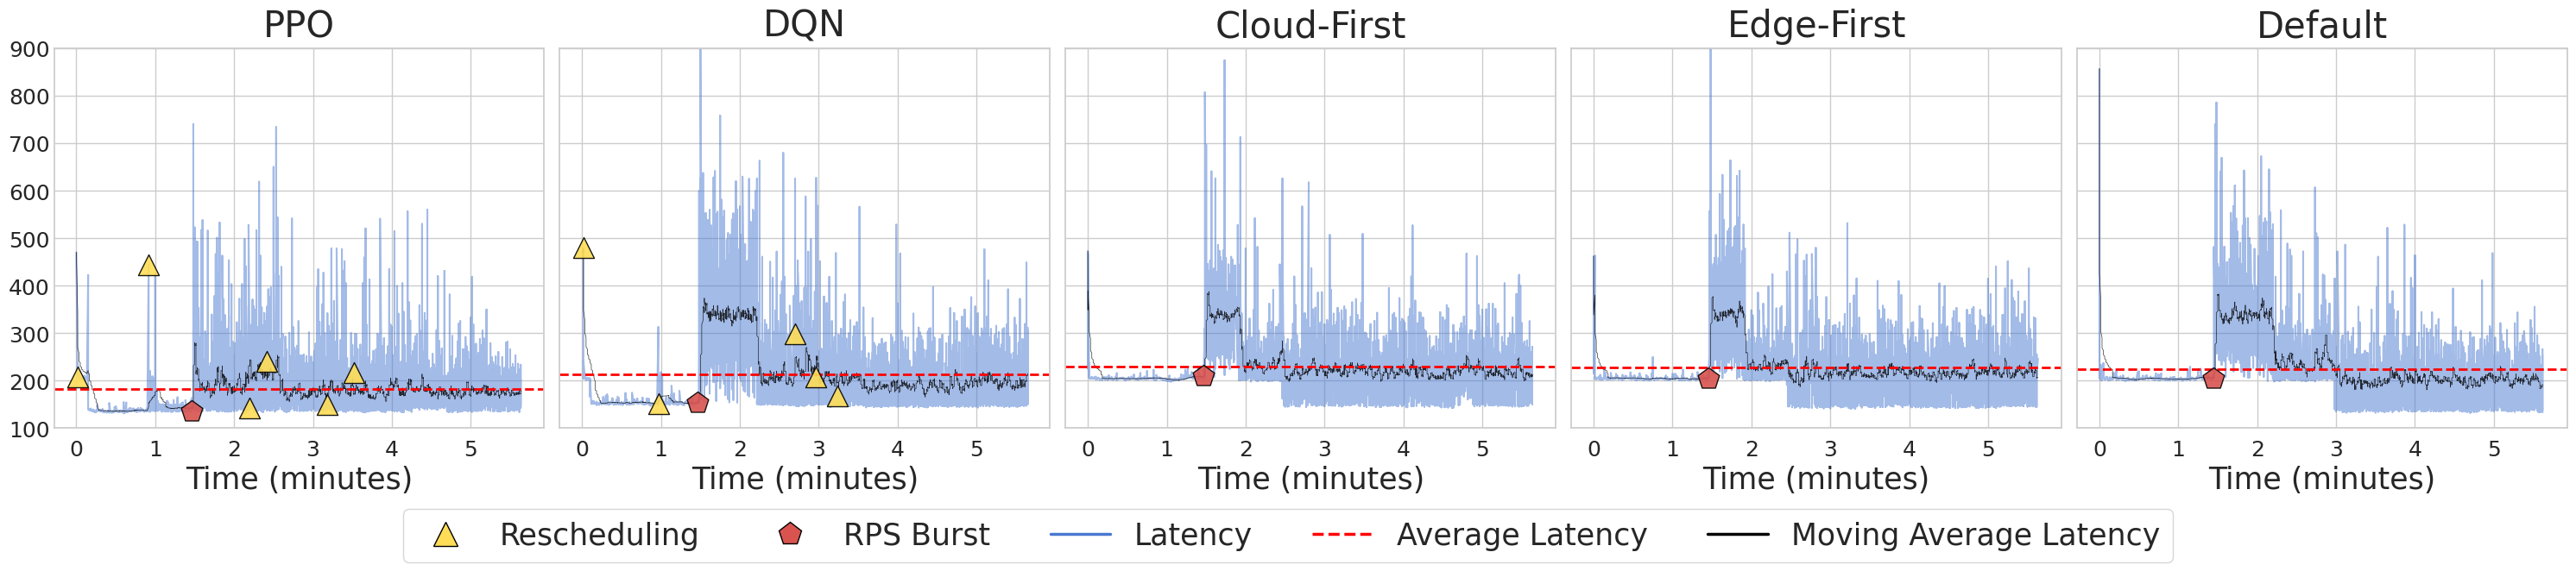

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set_theme(style="whitegrid")

msa_list = ["chain", "aggregator_sequential", "aggregator_parallel"]
strategy_list = ["ppo", "dqn", "cloud", "edge", "all"]

isTest = False
testDataPath = "results/nodefailed/aggregator_parallel_ppo_replica3.csv"

palette = sns.color_palette("muted", n_colors=5)

reschedule_color = "#ffdd57"
autoscaling_color = "#d9534f"
average_line_color = "#4d4d4d"

for msa in msa_list:
    fig = plt.figure(figsize=(30, 6))
    gs = fig.add_gridspec(1, 5)
    axes = gs.subplots(sharex=True, sharey=True) 

    latency_handles = []
    latency_labels = []

    ppo_latency_mean = None
    ppo_primary_color = None

    for idx, strategy in enumerate(strategy_list):
        # row = idx // 2
        # col = idx % 2
        ax = axes[idx]

        if isTest:
            data = pd.read_csv(testDataPath)
        else:
            data_path = f"results/autoscaling/{msa}_{strategy}.csv"
            if not os.path.exists(data_path):
                print(f"文件未找到: {data_path}")
                continue
            data = pd.read_csv(data_path)

        if data.empty:
            print(f"{msa} - {strategy}: 数据为空，跳过。")
            continue

        data['human_readable_timestamp'] = pd.to_datetime(data['human_readable_timestamp'], errors='coerce')
        data = data.dropna(subset=['human_readable_timestamp'])
        data = data.sort_values(by='human_readable_timestamp')

        experiment_start_time = data[data['event'] == 'experiment_start']['human_readable_timestamp'].min()
        print(f"{msa} - {strategy}: Experiment Start Time:", experiment_start_time)

        data = data[data['human_readable_timestamp'] > experiment_start_time]

        # print(f"{msa} - {strategy}: 过滤前行数: {len(data)}")
        # data = data[(data['latency'] >= 0) & (data['latency'] < 680)]
        # print(f"{msa} - {strategy}: 过滤后行数: {len(data)}")

        if data.empty:
            print(f"{msa} - {strategy}: 过滤后数据为空，跳过。")
            continue

        baseline_time = data['human_readable_timestamp'].min()
        data['relative_time'] = (data['human_readable_timestamp'] - baseline_time).dt.total_seconds() / 60

        data.loc[data['event'].isin(['experiment_end', 'node_recovered']), 'latency'] = None
        data['latency_moving_avg'] = data['latency'].rolling(window=40, min_periods=1).mean()

        latency_mean = data['latency'].mean()
        print(f"{msa} - {strategy}: 平均 Latency = {latency_mean:.2f} ms")

        # 计算延迟小于300ms的latency占总的百分比
        exceeded_count = (data['latency'] < 250).sum()
        exceeded_proportion = exceeded_count / len(data)
        print(f"{msa} - {strategy}: 延迟小于300ms的latency占总的百分比 = {exceeded_proportion:.2f}")
        primary_color = palette[idx % len(palette)]

        # 计算rps的平均值
        rps_mean = data['rps'].mean()
        print(f"{msa} - {strategy}: 平均 RPS = {rps_mean:.2f}")

        if strategy == 'ppo':
            ppo_latency_mean = latency_mean
            ppo_primary_color = primary_color

        ax.plot(data['relative_time'], data['latency'],
                color=palette[0], linewidth=1.5, alpha=0.5)

        ax.plot(data['relative_time'], data['latency_moving_avg'],
                color="black", linewidth=0.5, alpha=0.8)

        # line_handle = plt.Line2D([], [], color=palette[0], linewidth=2.5, label=f'{strategy.upper()}')
        # latency_handles.append(line_handle)
        # latency_labels.append(f'Latency')

        # if strategy == 'ppo':
        #     ax.axhline(latency_mean, color='blue', linestyle='--', linewidth=2.0)
        # else:
        ax.axhline(latency_mean, color="red", linestyle='--', linewidth=2.0)
            # if ppo_latency_mean is not None:
            #     ax.axhline(ppo_latency_mean, color="blue", linestyle='--', linewidth=2.0)

        reschedule_events = data[data['event'] == 'rescheduling']
        autoscaling_events = data[data['event'] == 'autoscaling']

        ax.scatter(reschedule_events['relative_time'], reschedule_events['latency'],
                   color=reschedule_color, label='Rescheduling', marker='^', s=300, edgecolor='black', alpha=0.9, zorder=5)

        ax.scatter(autoscaling_events['relative_time'], autoscaling_events['latency'],
                   color=autoscaling_color, label='RPS Burst', marker='p', s=350, edgecolor='black', alpha=0.9, zorder=5)

        ax.set_xlabel("Time (minutes)", fontsize=25)
        # ax.set_ylabel("Latency (ms)", fontsize=25)
        ax.set_ylim(100, 900)  # 固定 Latency 纵坐标范围为 0 - 500 ms
        ax.tick_params(axis='y', which='major', labelsize=18, length=0)
        ax.tick_params(axis='x', which='major', labelsize=18)
        # ax.grid(False)
        title_map = {
            "ppo": "PPO",
            "dqn": "DQN",
            "cloud": "Cloud-First",
            "edge": "Edge-First",
            "all": "Default"
        }
        ax.set_title(f"{title_map[strategy]}", fontsize=30, pad=10)

        # ax2 = ax.twinx()
        # ax2.plot(data['relative_time'], data['rps'], color="green", linewidth=1, label='RPS')
        # # ax2.set_ylabel("RPS", fontsize=25)
        # ax2.set_ylim(0, 35)  # 固定 RPS 纵坐标范围为 0 - 35
        # ax2.grid(False)
        # # ax2.tick_params(axis='y', which='major', labelsize=15)
        # if idx == len(strategy_list)-1:  # 只在最右边的图显示右y轴标签和刻度
        #     ax2.tick_params(axis='y', which='major', labelsize=18, length=0)
        # else:
        #     ax2.tick_params(axis='y', labelright=False, length=0)

    # axes[2][1].set_visible(False)
    line_handle = plt.Line2D([], [], color=palette[0], linewidth=2.5, label=f'Latency')
    latency_handles.append(line_handle)
    latency_labels.append(f'Latency')

    rescheduling_handle = plt.Line2D([], [], color=reschedule_color, marker='^', linestyle='None', markersize=20, markeredgecolor='black', label='Rescheduling')
    autoscaling_handle = plt.Line2D([], [], color=autoscaling_color, marker='p', linestyle='None', markersize=20, markeredgecolor='black', label='RPS Burst')
    average_line_handle = plt.Line2D([], [], color="red", linestyle='--', linewidth=2.5, label='Average Latency')
    moving_average_line_handle = plt.Line2D([], [], color="black", linestyle='-', linewidth=2.5, label='Moving Average Latency')
    # rps_line_handle = plt.Line2D([], [], color='green', linewidth=2.5, label='RPS')

    # if ppo_latency_mean is not None:
    #     ppo_average_line_handle = plt.Line2D([], [], color=ppo_primary_color, linestyle='--', linewidth=2.5, label='PPO Average Latency')
    #     legend_handles = (
    #         [rescheduling_handle, autoscaling_handle] +
    #         latency_handles +
    #         [average_line_handle, ppo_average_line_handle, moving_average_line_handle, rps_line_handle]
    #     )
    #     legend_labels = (
    #         ['Rescheduling', 'RPS Burst'] +
    #         latency_labels +
    #         ['Average Latency', 'PPO Average Latency', 'Moving Average Latency', 'RPS']
    #     )
    # else:
    legend_handles = (
        [rescheduling_handle, autoscaling_handle] +
        latency_handles +
        [average_line_handle, moving_average_line_handle]
    )
    legend_labels = (
        ['Rescheduling', 'RPS Burst'] +
        latency_labels +
        ['Average Latency', 'Moving Average Latency']
    )
    print(legend_labels)

    # labels_map = {
    #     'PPO': 'PPO',
    #     'DQN': 'DQN',
    #     'CLOUD': 'Cloud-First',
    #     'EDGE': 'Edge-First',
    #     'ALL': 'Default',
    #     'Rescheduling': 'Rescheduling',
    #     'RPS Burst': 'RPS Burst',
    #     'Average Latency': 'Average Latency',
    #     'PPO Average Latency': 'PPO Average Latency',
    #     'Moving Average Latency': 'Moving Average Latency',
    #     'RPS': 'RPS'
    # }
    labels_map = {
        "Latency": "Latency",
        'Rescheduling': 'Rescheduling',
        'RPS Burst': 'RPS Burst',
        'Average Latency': 'Average Latency',
        'PPO Average Latency': 'PPO Average Latency',
        'Moving Average Latency': 'Moving Average Latency',
    }
    fig.legend(legend_handles, [labels_map[label] for label in legend_labels], fontsize=25, ncol=7, loc='center', bbox_to_anchor=(0.5, -0.05))

    plt.tight_layout()
    # plt.subplots_adjust(left=0.06)
    # plt.subplots_adjust(wspace=0.4)
    plt.savefig(f"output/timeseries/autoscaling_{msa}.png", dpi=300, bbox_inches='tight')
    plt.show()


chain - ppo: Experiment Start Time: 2024-12-14 12:12:32
chain - ppo: Average RPS = 26.62
chain - dqn: Experiment Start Time: 2024-12-14 12:18:33
chain - dqn: Average RPS = 25.45
chain - cloud: Experiment Start Time: 2024-12-14 12:36:06
chain - cloud: Average RPS = 21.23
chain - edge: Experiment Start Time: 2024-12-14 12:42:07
chain - edge: Average RPS = 21.23
chain - all: Experiment Start Time: 2024-12-14 12:30:04
chain - all: Average RPS = 21.47


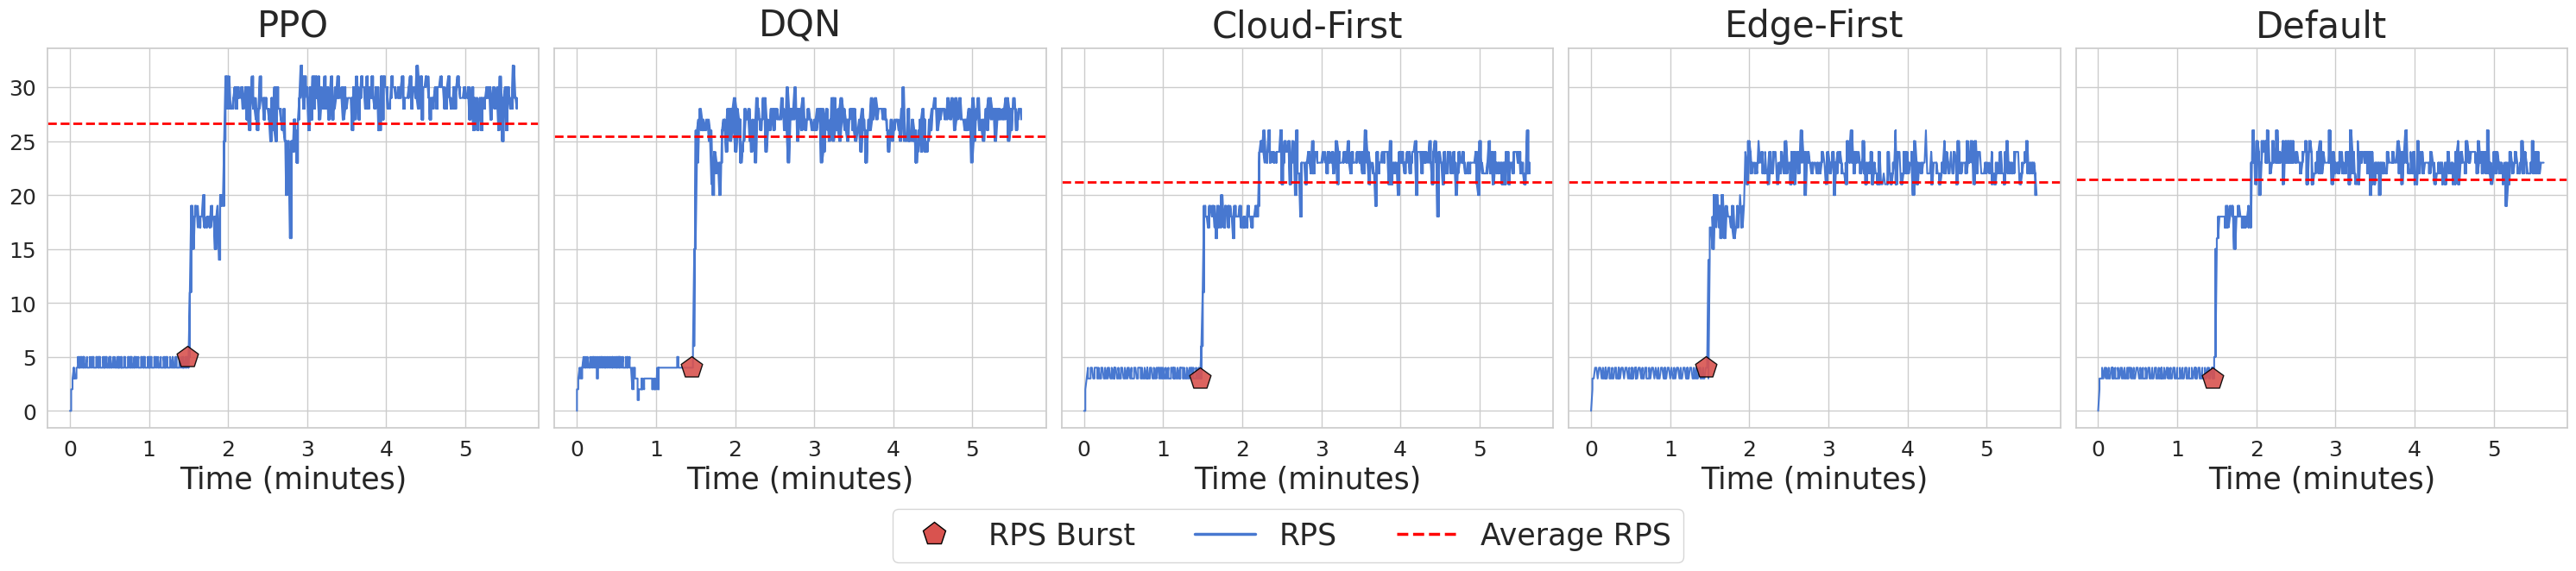

aggregator_sequential - ppo: Experiment Start Time: 2024-12-14 11:49:51
aggregator_sequential - ppo: Average RPS = 26.88
aggregator_sequential - dqn: Experiment Start Time: 2024-12-14 11:55:59
aggregator_sequential - dqn: Average RPS = 26.52
aggregator_sequential - cloud: Experiment Start Time: 2024-12-14 14:37:04
aggregator_sequential - cloud: Average RPS = 22.77
aggregator_sequential - edge: Experiment Start Time: 2024-12-14 14:43:10
aggregator_sequential - edge: Average RPS = 22.65
aggregator_sequential - all: Experiment Start Time: 2024-12-14 14:30:57
aggregator_sequential - all: Average RPS = 23.15


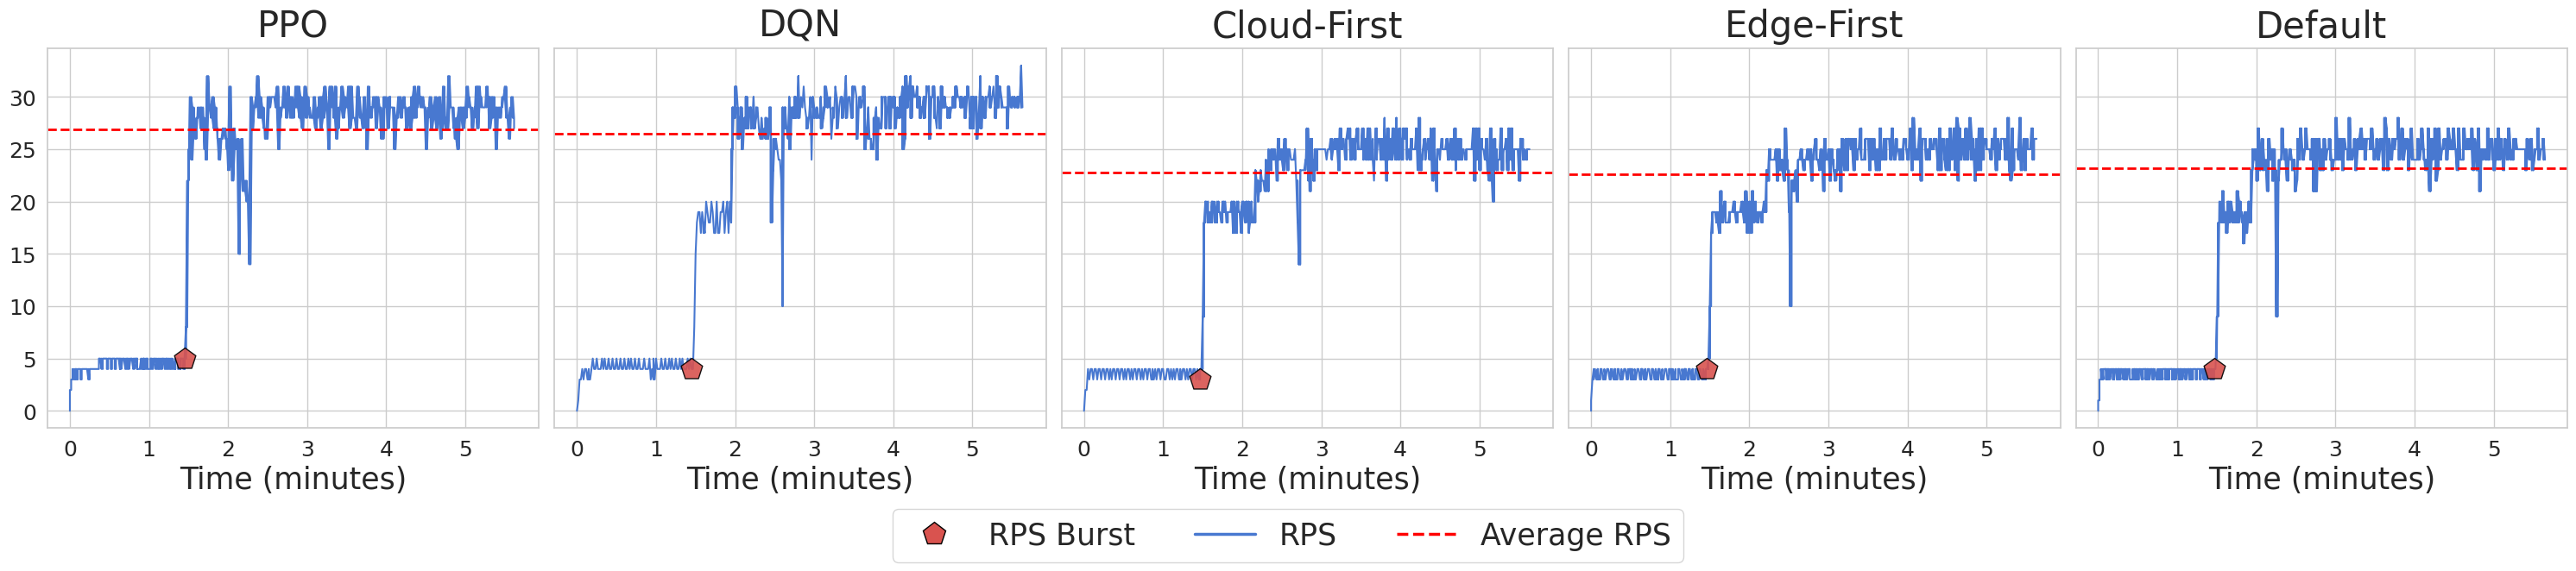

aggregator_parallel - ppo: Experiment Start Time: 2024-12-14 13:56:52
aggregator_parallel - ppo: Average RPS = 27.88
aggregator_parallel - dqn: Experiment Start Time: 2024-12-14 14:02:56
aggregator_parallel - dqn: Average RPS = 24.90
aggregator_parallel - cloud: Experiment Start Time: 2024-12-14 14:18:42
aggregator_parallel - cloud: Average RPS = 23.54
aggregator_parallel - edge: Experiment Start Time: 2024-12-14 14:24:50
aggregator_parallel - edge: Average RPS = 23.77
aggregator_parallel - all: Experiment Start Time: 2024-12-14 14:12:35
aggregator_parallel - all: Average RPS = 24.23


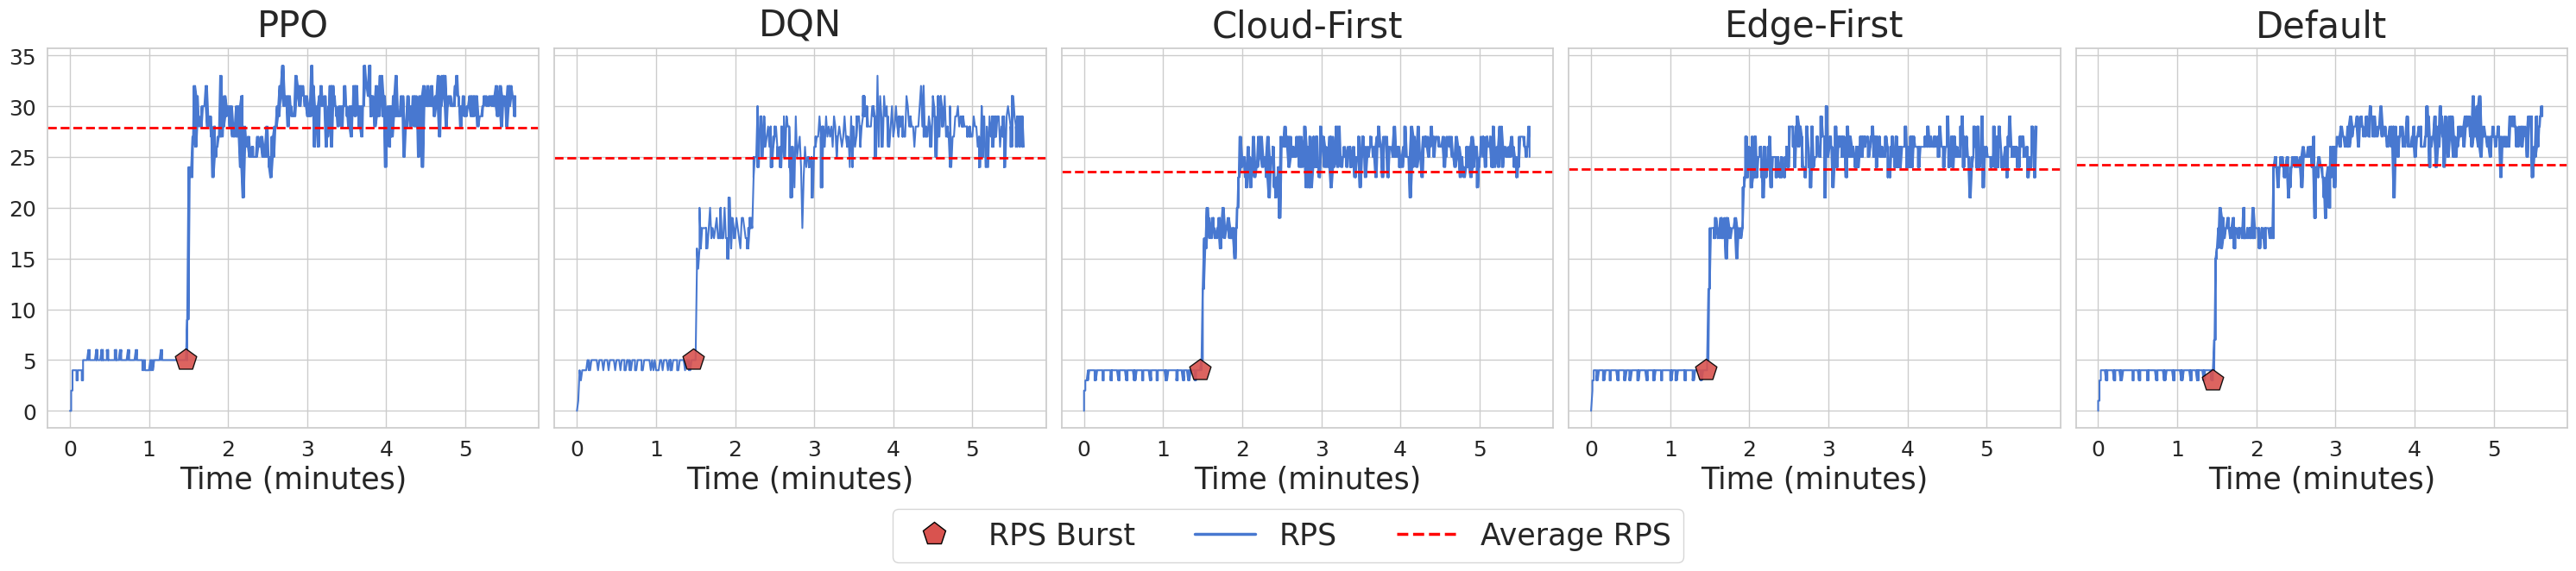

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set_theme(style="whitegrid")

msa_list = ["chain", "aggregator_sequential", "aggregator_parallel"]
strategy_list = ["ppo", "dqn", "cloud", "edge", "all"]

isTest = False
testDataPath = "results/nodefailed/aggregator_parallel_ppo_replica3.csv"

# Use only one color for all plots
primary_color = sns.color_palette("muted", n_colors=1)[0]
autoscaling_color = "#d9534f"
for msa in msa_list:
    # Create a figure with subplots for each strategy
    fig = plt.figure(figsize=(30, 6))
    gs = fig.add_gridspec(1, 5)
    axes = gs.subplots(sharex=True, sharey=True) 

    # Initialize legend elements to avoid duplication
    added_legend = set()

    for idx, strategy in enumerate(strategy_list):
        ax = axes[idx]

        if isTest:
            # Load test data if isTest is True
            data = pd.read_csv(testDataPath)
        else:
            # Construct file path for the data
            data_path = f"results/autoscaling/{msa}_{strategy}.csv"
            if not os.path.exists(data_path):
                print(f"File not found: {data_path}")
                continue
            data = pd.read_csv(data_path)

        if data.empty:
            # Skip if data is empty
            print(f"{msa} - {strategy}: Data is empty, skipping.")
            continue

        # Convert timestamp to datetime and drop invalid entries
        data['human_readable_timestamp'] = pd.to_datetime(data['human_readable_timestamp'], errors='coerce')
        data = data.dropna(subset=['human_readable_timestamp'])
        data = data.sort_values(by='human_readable_timestamp')

        # Determine experiment start time
        experiment_start_time = data[data['event'] == 'experiment_start']['human_readable_timestamp'].min()
        print(f"{msa} - {strategy}: Experiment Start Time: {experiment_start_time}")

        # Filter data to only include rows after experiment start
        data = data[data['human_readable_timestamp'] > experiment_start_time]

        if data.empty:
            print(f"{msa} - {strategy}: Filtered data is empty, skipping.")
            continue

        # Calculate relative time in minutes
        baseline_time = data['human_readable_timestamp'].min()
        data['relative_time'] = (data['human_readable_timestamp'] - baseline_time).dt.total_seconds() / 60

        # Calculate average RPS
        rps_mean = data['rps'].mean()
        print(f"{msa} - {strategy}: Average RPS = {rps_mean:.2f}")

        autoscaling_events = data[data['event'] == 'autoscaling']

        ax.scatter(autoscaling_events['relative_time'], autoscaling_events['rps'],
                   color=autoscaling_color, label='RPS Burst', marker='p', s=350, edgecolor='black', alpha=0.9, zorder=5)
        # Plot RPS time series
        ax.plot(data['relative_time'], data['rps'], color=primary_color, linewidth=1.5, label='RPS' if 'RPS' not in added_legend else "")
        # Plot average RPS as a horizontal line
        ax.axhline(rps_mean, color="red", linestyle="--", linewidth=2.0, label="Average RPS" if "Average RPS" not in added_legend else "")

        # Track added legend elements to prevent duplication
        added_legend.update(['RPS', 'Average RPS'])

        # Set axis labels and tick parameters
        ax.set_xlabel("Time (minutes)", fontsize=25)
        ax.tick_params(axis='y', labelsize=18)
        ax.tick_params(axis='x', labelsize=18)

        # Set subplot title based on strategy
        title_map = {
            "ppo": "PPO",
            "dqn": "DQN",
            "cloud": "Cloud-First",
            "edge": "Edge-First",
            "all": "Default"
        }
        ax.set_title(f"{title_map.get(strategy, strategy.upper())}", fontsize=30, pad=10)

    line_handle = plt.Line2D([], [], color=palette[0], linewidth=2.5, label=f'Latency')
    autoscaling_handle = plt.Line2D([], [], color=autoscaling_color, marker='p', linestyle='None', markersize=20, markeredgecolor='black', label='RPS Burst')
    average_line_handle = plt.Line2D([], [], color="red", linestyle='--', linewidth=2.5, label='Average Latency')

    legend_handles = [autoscaling_handle, line_handle, average_line_handle]
    legend_labels = ['RPS Burst', 'RPS', 'Average RPS']

    # Add a shared legend above the plots
    fig.legend(legend_handles, legend_labels, fontsize=25, ncol=3, loc='center', bbox_to_anchor=(0.5, -0.05))
    plt.tight_layout()
    # Save the figure to file
    plt.savefig(f"output/timeseries/rps_{msa}.png", dpi=300, bbox_inches='tight')
    plt.show()
